In [1]:
import os
import time
import copy
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

import shap

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [2]:
!unzip -q "/content/MetdataDataset.zip" -d /content/dataset

In [3]:
#
train_images_folder = '/content/dataset/MetdataDataset/Doctor’s Handwritten Prescription BD dataset/Training/training_words'
val_images_folder   = '/content/dataset/MetdataDataset/Doctor’s Handwritten Prescription BD dataset/Validation/validation_words'
test_images_folder  = '/content/dataset/MetdataDataset/Doctor’s Handwritten Prescription BD dataset/Testing/testing_words'

train_label_file = '/content/dataset/MetdataDataset/Doctor’s Handwritten Prescription BD dataset/Training/training_labels_updated.csv'
val_label_file   = '/content/dataset/MetdataDataset/Doctor’s Handwritten Prescription BD dataset/Validation/validation_labels_updated.csv'
test_label_file  = '/content/dataset/MetdataDataset/Doctor’s Handwritten Prescription BD dataset/Testing/testing_labels_updated.csv'


metadata_columns = [
    'drug_category',
    'dosage_form',
    'otc_status',

]

target_col = 'MEDICINE_NAME'

In [4]:
import pandas as pd
import os

def check_master_leakage(train_file, val_file, test_file,
                         train_img_dir, val_img_dir, test_img_dir,
                         metadata_columns, target_col="MEDICINE_NAME"):
    # Load CSVs
    train_df = pd.read_csv(train_file)
    val_df   = pd.read_csv(val_file)
    test_df  = pd.read_csv(test_file)
    metadata_leakage = {}
    for col in metadata_columns:
        mapping = train_df.groupby(col)[target_col].nunique()
        unique_leak = mapping[mapping == 1]
        metadata_leakage[col] = len(unique_leak)

    return train_df, val_df, test_df, metadata_leakage

In [5]:
train_df, val_df, test_df, metadata_leakage = check_master_leakage(
    train_label_file,
    val_label_file,
    test_label_file,
    train_images_folder,
    val_images_folder,
    test_images_folder,
    metadata_columns,
    target_col="MEDICINE_NAME"
)

print("Metadata Leakage:", metadata_leakage)

Metadata Leakage: {'drug_category': 1, 'dosage_form': 2, 'otc_status': 0}


In [6]:
def remove_rare_leaks(df, metadata_columns, target_col):

    df_clean = df.copy()
    for col in metadata_columns:
        counts = df.groupby(col)[target_col].nunique()
        rare_values = counts[counts == 1].index
        df_clean.loc[df_clean[col].isin(rare_values), col] = None
    return df_clean


In [7]:
train_df_clean = remove_rare_leaks(train_df, metadata_columns, target_col)
val_df_clean   = remove_rare_leaks(val_df, metadata_columns, target_col)
test_df_clean  = remove_rare_leaks(test_df, metadata_columns, target_col)


In [8]:
def verify_metadata_leakage(df, metadata_columns, target_col):
    leakage_info = {}
    for col in metadata_columns:
        counts = df.groupby(col)[target_col].nunique()
        leakage_info[col] = len(counts[counts == 1])
    return leakage_info

metadata_leak_check_train = verify_metadata_leakage(train_df_clean, metadata_columns, target_col)
print("Metadata leakage after cleaning:", metadata_leak_check_train)


Metadata leakage after cleaning: {'drug_category': 0, 'dosage_form': 0, 'otc_status': 0}


In [9]:
# ---- Dataset class ----
class PrescriptionDataset(Dataset):
    def __init__(self, images_folder, df, metadata_cols, target_col, transform=None):
        self.images_folder = images_folder
        self.df = df
        self.metadata_cols = metadata_cols
        self.target_col = target_col
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.images_folder, row['IMAGE'])
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(image=np.array(img))['image']

        meta_features = torch.tensor([row[col] for col in self.metadata_cols], dtype=torch.long)
        label = torch.tensor(row[self.target_col], dtype=torch.long)
        return img, meta_features, label

In [10]:
train_transform = A.Compose([
    A.Resize(224, 224),
    A.Rotate(limit=15, p=0.7),
    A.Affine(translate_percent=0.05, scale=(0.9, 1.1), rotate=0, shear=0, p=0.5),
    A.ElasticTransform(alpha=1, sigma=50, p=0.3),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.GaussNoise(p=0.4),
    A.OneOf([
        A.MotionBlur(blur_limit=3, p=1.0),
        A.MedianBlur(blur_limit=3, p=1.0),
        A.Blur(blur_limit=3, p=1.0),
    ], p=0.3),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.3),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_test_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

In [11]:
# ---- Load CSVs ----
df_train = pd.read_csv(train_label_file)
df_val = pd.read_csv(val_label_file)
df_test = pd.read_csv(test_label_file)

for df in [df_train, df_val, df_test]:
    df.columns = df.columns.str.strip()

# ---- Label encoding ----
encoders = {}
for col in metadata_columns + [target_col]:
    le = LabelEncoder()
    le.fit(df_train[col])
    encoders[col] = le
    df_train[col] = le.transform(df_train[col])
    df_val[col] = le.transform(df_val[col])
    df_test[col] = le.transform(df_test[col])

num_classes = len(encoders[target_col].classes_)
metadata_cardinalities = [len(encoders[col].classes_) for col in metadata_columns]

print(f"Num classes: {num_classes}")
print(f"Metadata cardinalities: {metadata_cardinalities}")


Num classes: 78
Metadata cardinalities: [13, 5, 3]


In [12]:
batch_size = 6
num_workers = 2

train_ds = PrescriptionDataset(train_images_folder, df_train, metadata_columns, target_col, transform=train_transform)
val_ds = PrescriptionDataset(val_images_folder, df_val, metadata_columns, target_col, transform=val_test_transform)
test_ds = PrescriptionDataset(test_images_folder, df_test, metadata_columns, target_col, transform=val_test_transform)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)

print(f"Train/Val/Test sizes: {len(train_ds)}, {len(val_ds)}, {len(test_ds)}")


Train/Val/Test sizes: 3120, 780, 780


In [13]:
class MultiModalResNet(nn.Module):
    def __init__(self, num_classes, metadata_cardinalities, embed_dim=16):
        super().__init__()
        base_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.cnn = nn.Sequential(*list(base_model.children())[:-1]) # Remove the last FC layer
        self.flatten = nn.Flatten()

        self.cnn_fc = nn.Sequential(
            nn.Linear(2048, 512), # ResNet50 outputs 2048 features before the final FC layer
            nn.ReLU(),
            nn.Dropout(0.5)
        )

        self.metadata_embeds = nn.ModuleList(
            [nn.Embedding(cardinality, embed_dim) for cardinality in metadata_cardinalities]
        )

        self.fc = nn.Sequential(
            nn.Linear(512 + embed_dim * len(metadata_cardinalities), 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x_img, x_meta):
        x_img = self.cnn(x_img)
        x_img = self.flatten(x_img)   # [batch, 2048]
        x_img = self.cnn_fc(x_img)    # [batch, 512]

        meta_embeds = [embed(x_meta[:, i]) for i, embed in enumerate(self.metadata_embeds)]
        x_meta = torch.cat(meta_embeds, dim=1)

        x = torch.cat([x_img, x_meta], dim=1)
        out = self.fc(x)
        return out

In [14]:
def train_validate(model, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=36, save_path='best_multimodal.pth', patience=5):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    early_stop_counter = 0

    for epoch in range(num_epochs):
        # Train
        model.train()
        running_loss, running_corrects, total = 0, 0, 0
        for imgs, metas, labels in train_loader:
            imgs, metas, labels = imgs.to(device), metas.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs, metas)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * imgs.size(0)
            running_corrects += torch.sum(preds == labels).item()
            total += imgs.size(0)

        train_loss = running_loss / total
        train_acc = running_corrects / total

        # Validate
        model.eval()
        val_running_loss, val_running_corrects, val_total = 0, 0, 0
        with torch.no_grad():
            for imgs, metas, labels in val_loader:
                imgs, metas, labels = imgs.to(device), metas.to(device), labels.to(device)
                outputs = model(imgs, metas)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                val_running_loss += loss.item() * imgs.size(0)
                val_running_corrects += torch.sum(preds == labels).item()
                val_total += imgs.size(0)

        val_loss = val_running_loss / val_total
        val_acc = val_running_corrects / val_total

        if scheduler is not None:
            scheduler.step(val_loss)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} | Train loss: {train_loss:.4f} acc: {train_acc:.4f} | Val loss: {val_loss:.4f} acc: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), save_path)
            early_stop_counter = 0
            print("  Saved best model.")
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print("Early stopping triggered.")
                break

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s | Best val Acc: {best_acc:.4f}")

    model.load_state_dict(best_model_wts)

    # Plot loss/accuracy curves
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title("Loss Curve")
    plt.subplot(1,2,2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.legend()
    plt.title("Accuracy Curve")
    plt.show()

    return model, history


In [15]:
def evaluate_and_report_avg(model, loader, id_to_label):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for imgs, metas, labels in loader:
            imgs, metas, labels = imgs.to(device), metas.to(device), labels.to(device)
            outputs = model(imgs, metas)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    print(f"Test Accuracy: {acc:.4f}")
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    avg_metrics = {
        'precision': report['weighted avg']['precision'],
        'recall': report['weighted avg']['recall'],
        'f1-score': report['weighted avg']['f1-score'],
        'accuracy': report['accuracy']
    }
    print("Average Metrics (weighted):", avg_metrics)
    return avg_metrics

In [16]:
model = MultiModalResNet(num_classes=num_classes, metadata_cardinalities=metadata_cardinalities).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 173MB/s]


Epoch 1/30 | Train loss: 4.3156 acc: 0.0295 | Val loss: 4.1886 acc: 0.1103
  Saved best model.
Epoch 2/30 | Train loss: 4.1466 acc: 0.0747 | Val loss: 3.8233 acc: 0.2756
  Saved best model.
Epoch 3/30 | Train loss: 3.8470 acc: 0.1285 | Val loss: 3.3039 acc: 0.3808
  Saved best model.
Epoch 4/30 | Train loss: 3.4439 acc: 0.1968 | Val loss: 2.6698 acc: 0.4526
  Saved best model.
Epoch 5/30 | Train loss: 2.9840 acc: 0.2795 | Val loss: 2.0549 acc: 0.6846
  Saved best model.
Epoch 6/30 | Train loss: 2.5345 acc: 0.3676 | Val loss: 1.4890 acc: 0.7692
  Saved best model.
Epoch 7/30 | Train loss: 2.1328 acc: 0.4667 | Val loss: 0.9620 acc: 0.8462
  Saved best model.
Epoch 8/30 | Train loss: 1.7296 acc: 0.5500 | Val loss: 0.7294 acc: 0.8987
  Saved best model.
Epoch 9/30 | Train loss: 1.4152 acc: 0.6420 | Val loss: 0.5476 acc: 0.9167
  Saved best model.
Epoch 10/30 | Train loss: 1.1381 acc: 0.7090 | Val loss: 0.3968 acc: 0.9282
  Saved best model.
Epoch 11/30 | Train loss: 0.9621 acc: 0.7587 | Va

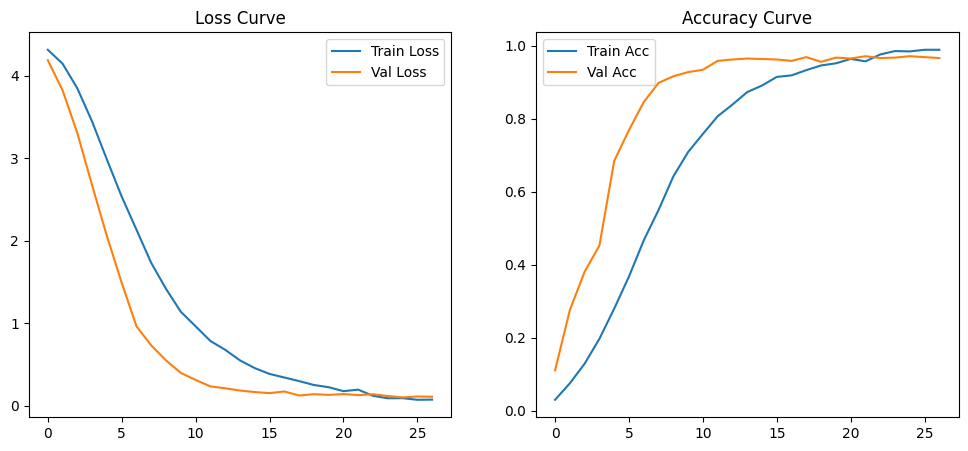

In [17]:
model, history = train_validate(model, train_loader, val_loader, criterion, optimizer, scheduler=scheduler, num_epochs=30)


In [18]:
id_to_label = {i:c for i,c in enumerate(encoders[target_col].classes_)}
_ = evaluate_and_report_avg(model, test_loader, id_to_label)

Test Accuracy: 0.9449
Average Metrics (weighted): {'precision': 0.9498888575811653, 'recall': 0.9448717948717948, 'f1-score': 0.9438976107050545, 'accuracy': 0.9448717948717948}
